In [ ]:
#Importación de librerías para carga de datos
from keras.datasets import mnist

In [ ]:
#Carga de datos de MNIST
(train_X, train_y), (test_X, test_y) = mnist.load_data()

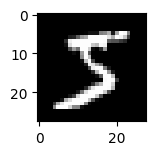

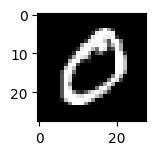

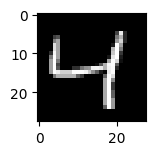

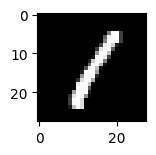

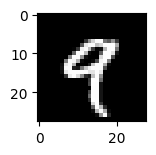

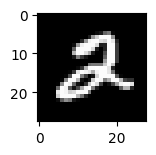

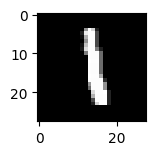

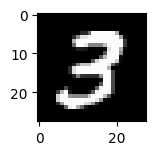

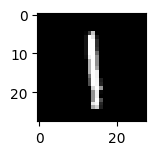

In [ ]:
#Ciclo para validar que los datos hayan sido importados
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [ ]:
# Normalización
# Convierte las imágenes de entrenamiento a valores de punto flotante
# y luego las normaliza dividiendo cada pixel por 255.0, lo que escala los valores de los píxeles en el rango [0, 1]
x_train_normalized = train_X.astype('float32') / 255.0
x_test_normalized = test_X.astype('float32') / 255.0

# Escalado entre -1 y 1
# Para que los valores oscilen entre -1 y 1, es necesario que el punto medio esté en cero.
# Actualmente, después de la normalización, el punto medio es 0.5. Al restar 0.5, los valores se centran en torno a cero.
# Una vez centrados alrededor de cero, multiplicar por 2.0 hace que los valores oscilen en el rango [-1, 1].
# Esto se debe a que si restamos 0.5, los valores estarán en el rango [-0.5, 0.5]. Al multiplicar por 2.0, los valores se escalan al rango final de [-1, 1].
x_train_scaled = (x_train_normalized - 0.5) * 2.0
x_test_scaled = (x_test_normalized - 0.5) * 2.0

# Ahora x_train_scaled y x_test_scaled contienen las imágenes escaladas entre -1 y 1

In [ ]:
x_train_scaled.shape

(60000, 28, 28)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

#Función del generador con LeakyReLU y Tanh
def init_generator(distance_lat):
  #Creación de pila lineal de capas con Sequential
  #Capas en medio de LeakyReLU para ayudar a que los valores se mantengan en el rango
  mdl_generator = tf.keras.Sequential(
      [
        #Primera capa densamente conectada (completamente conectada) con 100 neuronas
        # 7*7*128 es la redimensión que va a tener en la capa
        layers.Dense(7 * 7 * 128, input_dim=distance_lat, name="layer1"),
        #layers.Dense(100, input_dim=distance_lat, name="layer1"),
        #Segunda capa con función de activación LeakyReLU con alpha para acercar los números al valor positivo
        layers.LeakyReLU(alpha=0.02, name="layer2"),
        #Capa de redimensionamiento de 7 x 7 x 128
        layers.Reshape((7,7,128)),
        #Capa que usa 64 neuronas para construir la imagen. Filtrando 4x4
        #Strides moviéndose 2x2 y padding manteniendo la forma
        layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'),
        #Capa adicional para ajustar datos
        layers.LeakyReLU(alpha=0.2),
        #Capa final que devuelve valor entre -1 y 1 por la función Tangente Hiperbólica
        layers.Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', activation="tanh"),
      ]
  )
  return mdl_generator

#Función del generador con Tanh
def init_generator_tanh(distance_lat):
  #Creación de pila lineal de capas con Sequential
  mdl_generator = tf.keras.Sequential(
      [
        #Primera capa densamente conectada (completamente conectada) con 100 neuronas
        layers.Dense(100, input_dim=distance_lat, name="layer1"),
        layers.Activation('tanh', name="layer2"),
        layers.Dense(1, name="layer3"),
      ]
  )
  return mdl_generator

In [ ]:
#Discriminador que devuelve probabilidad de sintetico o real, devolviendo el error al generador
def init_discriminator():
  mdl_discriminator = tf.keras.Sequential(
      [
          #Reducir el tamaño de las caracterísitcas
          layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
          layers.LeakyReLU(alpha=0.2),
          #Técnica para evitar el sobre ajuste desactivando aleatoriamente las neuronas
          layers.Dropout(0.4),
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
          layers.LeakyReLU(alpha=2.0),
          layers.Dropout(0.4),
          #Capa de aplanamiento donde los valores pasan a ser un vector para entrar a la capa densa
          layers.Flatten(),
          #Función de activación sigmoide para identificar los sinteticos y los reales
          #Acercar los valores al real según la función sigmoide
          #Devuelve probabilidad
          layers.Dense(1, activation='sigmoid')
      ]
  )
  return mdl_discriminator

In [ ]:
#DEFINIR DIMENSIÓN
distance_lat = 100

# Construir y compilar el discriminador
discriminatorModel = init_discriminator()
#Discriminador un clasificador binario
#Usa el optimizador Adam Estimación Adaptativa de Momentos que ajusta los parámetros
discriminatorModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Construir generador
generatorModel = init_generator(distance_lat)

In [ ]:
#Consturir red GAN
discriminatorModel.trainable = False
#Entrada que se crea con la dimensión para el generador
gan_input = tf.keras.Input(shape=(distance_lat,))
#La salida generada es X, siendo la entrada del discriminador (la iamgen sintetizada)
x = generatorModel(gan_input)
#Salida de la red gan
gan_output = discriminatorModel(x)
#Crear modelo pasando el espacio latente y la salida del discriminador
gan = tf.keras.Model(gan_input, gan_output)
#Salida binaria
#Adam: El que mejor se adapta para ajustar hiperparámetros en redes neuronales
gan.compile(loss='binary_crossentropy', optimizer='adam')

4/4 [==============================] - 5s 5ms/step
Epoch 0, D Loss: 0.7695265710353851, G Loss: 0.6812170743942261
4/4 [==============================] - 0s 3ms/step


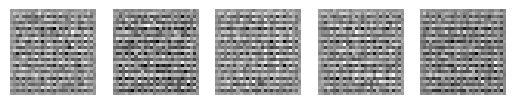

4/4 [==============================] - 0s 3ms/step
Epoch 3000, D Loss: 0.5137336999177933, G Loss: 1.5551422834396362
4/4 [==============================] - 0s 3ms/step


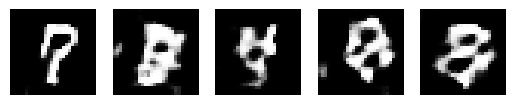

4/4 [==============================] - 0s 5ms/step
Epoch 6000, D Loss: 0.6999990046024323, G Loss: 1.131541132926941
4/4 [==============================] - 0s 2ms/step


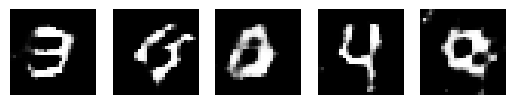

4/4 [==============================] - 0s 2ms/step
Epoch 9000, D Loss: 0.6327508687973022, G Loss: 0.9923000335693359
4/4 [==============================] - 0s 2ms/step


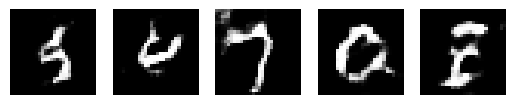

4/4 [==============================] - 0s 3ms/step


In [ ]:
import numpy as np

#Entrenamiento
batch_size=128
epochs=10000
sample_interval=3000

for epoch in range(epochs):
  #Entrenamiento discriminador
  #Creación de índice para identificar la imagen
  idx = np.random.randint(0, x_train_scaled.shape[0], batch_size)
  #Traer muestra del índice aleatorio
  real_images = x_train_scaled[idx]
  #Crear el ruido (espacio latente) siguiendo una distribución normal, entre 0 y 1.
  #Pasando el lote de impagenes y el espacio latente
  noise = np.random.normal(0, 1, (batch_size, distance_lat))
  #Se generan las imágenes con el ruido con el método de predecir
  generated_images = generatorModel.predict(noise)
  #LABELS se van ajustando en train_on_batch
  #Entradas reales en 1 de acuerdo al batch size
  real_labels = np.ones((batch_size, 1))
  #Entradas sinteticas en 0 de acuerdo al batch size
  fake_labels = np.zeros((batch_size, 1))

  #Calcular la función de pérdida del discriminador para datos reales
  d_loss_real = discriminatorModel.train_on_batch(real_images, real_labels)
  #Calcular la función de pérdida del discriminador para datos sinteticos
  d_loss_fake = discriminatorModel.train_on_batch(generated_images, fake_labels)
  #Se suman las pérdidas y se divide en dos
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  #Entrenamiento generador
  #Generar el ruido
  noise = np.random.normal(0, 1, (batch_size, distance_lat))
  #Definir función de pérdida del generador, pasando el ruido y las etiquetas reales
  g_loss = gan.train_on_batch(noise, real_labels)

  if epoch % sample_interval == 0:
    print(f'Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}')
    #Generar imágenes de ejemplo
    generated_images = generatorModel.predict(noise)
    generated_images = 0.5 * generated_images + 0.5 #Reescalar imágenes a [0,1]
    fig, axs = pyplot.subplots(1, 5)
    for i in range(5):
      axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
      axs[i].axis('off')
    pyplot.show()

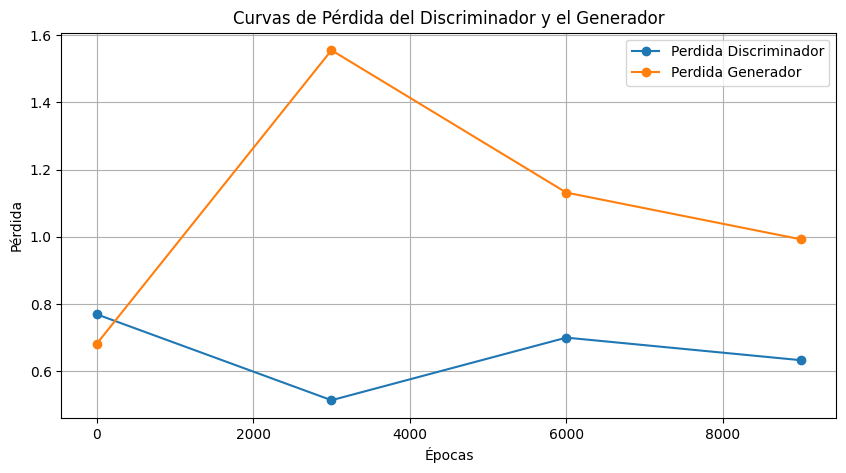

In [ ]:
import matplotlib.pyplot as plt



# Pérdidas proporcionadas
d_loss_arr = [0.7695265710353851, 0.5137336999177933, 0.6999990046024323, 0.6327508687973022]
g_loss_arr = [0.6812170743942261, 1.5551422834396362, 1.131541132926941, 0.9923000335693359]

# Número de épocas correspondiente
epochs = [0, 3000, 6000, 9000]

# Crear las curvas de pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, d_loss_arr, label='Perdida Discriminador', marker='o')
plt.plot(epochs, g_loss_arr, label='Perdida Generador', marker='o')

# Personalización del gráfico
plt.title('Curvas de Pérdida del Discriminador y el Generador')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [ ]:
generatorModel.save('generatorModel.h5')

In [ ]:
import tensorflow as tf
generatorModel = tf.keras.models.load_model('generatorModel.h5')

In [ ]:
import numpy as np
#OPERACION
num_samples = 10 #Cantidad de imágenes que deseas generar
latent_dim = 100 #Dimensión espacio latente

noise = np.random.normal(0, 1, (num_samples, latent_dim))

In [ ]:
noise[0][0] = 0.5

In [ ]:
generated_images = generatorModel.predict(noise)

1/1 [==============================] - 0s 17ms/step


In [ ]:
noise

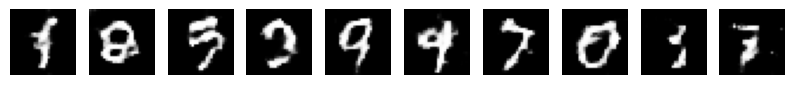

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
  axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
  axs[i].axis('off')
plt.show()